<a href="https://colab.research.google.com/github/trudo311399/Dog-or-Cat/blob/main/Dog_or_Cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
!unzip -q /content/drive/'My Drive'/AI_COLAB/dogs-vs-cats.zip

In [ ]:
!unzip -q /content/test1.zip
!unzip -q /content/train.zip

In [ ]:
!ls

drive  sample_data  sampleSubmission.csv  test1  test1.zip  train  train.zip


#Xử lý dữ liệu




In [ ]:
!pip install numpy
!pip install pandas
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install tf-nightly --quiet

     |████████████████████████████████| 322.9MB 48kB/s 
     |████████████████████████████████| 3.0MB 48.8MB/s 
     |████████████████████████████████| 460kB 45.3MB/s 


## 1.   Khai báo các thư viện

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

## 2.   Xác định các thông số ảnh



In [ ]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

##3. Chuẩn bị dữ liệu đào tạo

In [ ]:
filenames = os.listdir("/content/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(0)
    else:
        categories.append(1)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df.head()

,filename,category
0,dog.12155.jpg,0
1,cat.2869.jpg,1
2,cat.908.jpg,1
3,cat.1611.jpg,1
4,dog.11444.jpg,0


In [ ]:
df.tail()

,filename,category
24995,dog.5391.jpg,0
24996,cat.2781.jpg,1
24997,cat.9633.jpg,1
24998,dog.8872.jpg,0
24999,cat.9987.jpg,1


##4. Xem số lượng 2 lớp Chó và Mèo

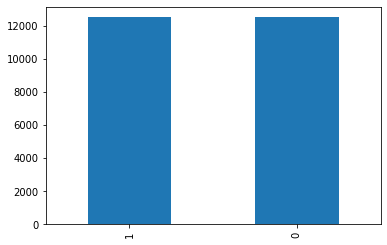

In [ ]:
df['category'].value_counts().plot.bar()

Hai lớp Chó và Mèo có ~12500 mẫu dữ liệu

##5. Xem một hình ảnh từ tập huấn luyện

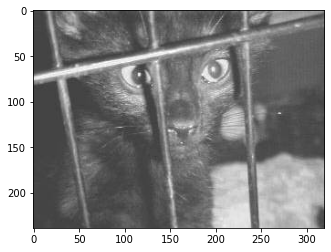

In [ ]:
sample = random.choice(filenames)
image = load_img("/content/train/"+sample)
plt.imshow(image)

#Xây dựng mô hình

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

#Callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

Điều kiện dừng: sau 10 epochs và giá trị val_loss không giảm

In [ ]:
earlystop = EarlyStopping(patience=10)

Hằng số học: giảm khi val_accuracy không tăng trong 2 bước

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
google_drive_dir = "/content/drive/My Drive/models/"
base_file_name = "test_new"

checkpointer = ModelCheckpoint(
    filepath = google_drive_dir + base_file_name + ".{epoch:02d}-{val_loss:.2f}.hdf5", 
    verbose = 1, 
    save_best_only = True, 
    monitor = "val_accuracy",
    mode = "max"
    )

In [ ]:
callbacks = [checkpointer, earlystop, learning_rate_reduction]

#Chuẩn bị dữ liệu

In [ ]:
df["category"] = df["category"].replace({0: 'dog', 1: 'cat'})

In [ ]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

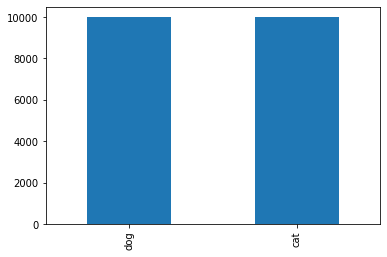

In [ ]:
train_df['category'].value_counts().plot.bar()

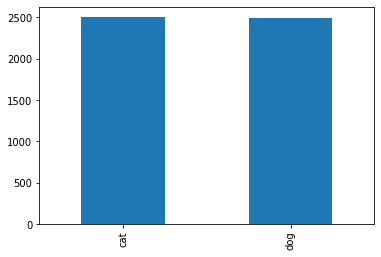

In [ ]:
validate_df['category'].value_counts().plot.bar()

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=32

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


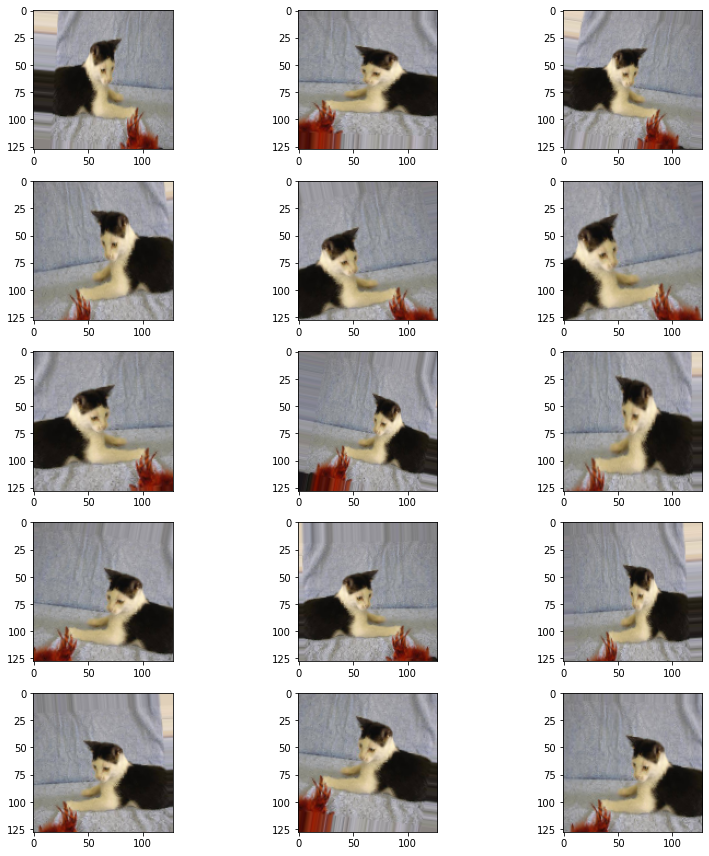

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

#Fit model

In [ ]:
epochs=3 if FAST_RUN else 20

history = model.fit(
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate//batch_size,
    steps_per_epoch = total_train//batch_size,
    callbacks = callbacks
)

Epoch 1/20
625/625 [==============================] - ETA: 0s - loss: 0.6904 - accuracy: 0.6707
Epoch 00001: val_accuracy improved from -inf to 0.66887, saving model to /content/drive/My Drive/models/test_new.01-0.70.hdf5
625/625 [==============================] - 1034s 2s/step - loss: 0.6904 - accuracy: 0.6707 - val_loss: 0.7006 - val_accuracy: 0.6689
Epoch 2/20
625/625 [==============================] - ETA: 0s - loss: 0.5040 - accuracy: 0.7574
Epoch 00002: val_accuracy did not improve from 0.66887
625/625 [==============================] - 1033s 2s/step - loss: 0.5040 - accuracy: 0.7574 - val_loss: 1.1415 - val_accuracy: 0.6348
Epoch 3/20
625/625 [==============================] - ETA: 0s - loss: 0.4461 - accuracy: 0.7912
Epoch 00003: val_accuracy did not improve from 0.66887

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
625/625 [==============================] - 1030s 2s/step - loss: 0.4461 - accuracy: 0.7912 - val_loss: 0.8987 - val_accuracy: 0.6

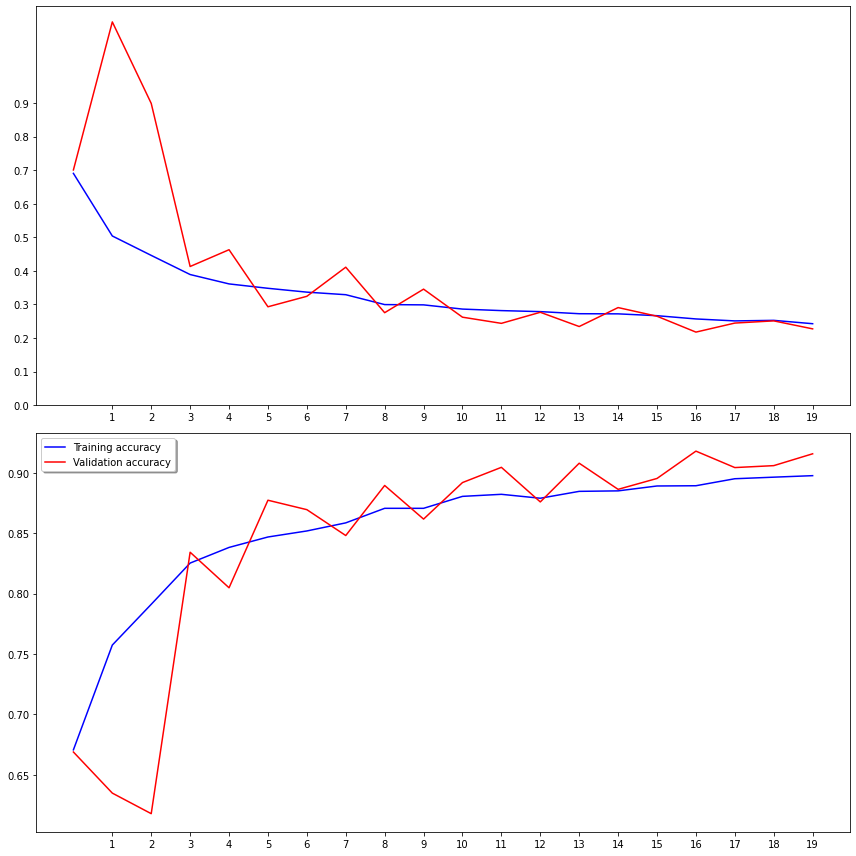

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_xticks(np.arange(1, 20, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
test_filenames = os.listdir("/content/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [ ]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [ ]:
test_df['category'] = np.argmax(predict, axis=-1)

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [ ]:
test_df['category'] = test_df['category'].replace({ 'cat': 1, 'dog': 0 })

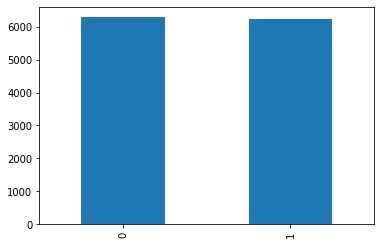

In [ ]:
test_df['category'].value_counts().plot.bar()

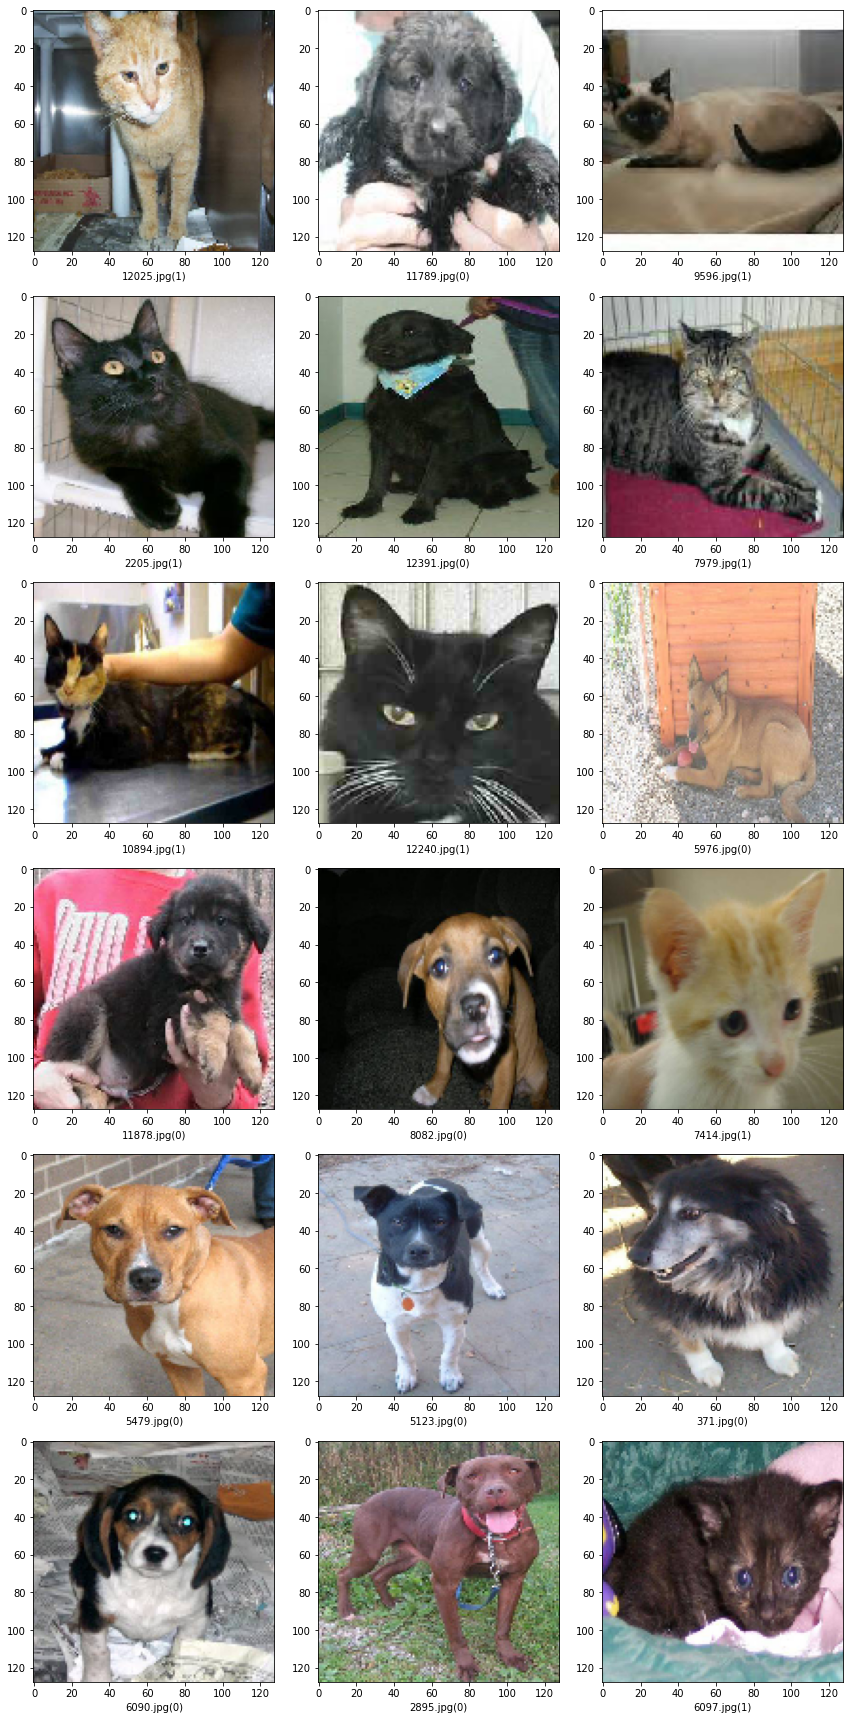

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission_test.csv', index=False)